## Poročilo vaja 4.3
#### Analiza variance: vpliv treninga na VO2max

Zanima nas vpliv drugačnega treninga na povišanje vo2max pri srednje treniranih moških glede na običajni tip trening. Imamo dve skupini (eksperimentalno in kontrolno). Meritve VO2max izvajo pred začetkom treninga in po 5ih, 10ih 15ih in 20ih tednih treninga.

Zanimajo nas tako uspešnost treninga na povišanje VO2max in razlike med skupinama. Podatki sov datoteki: *vo2max-anova-repeated-2gps-gen.savI.

1. Izvedite opisno statistiko in jo opremite z ustreznimi grafi.
2. Izvedite ustrezno statistično analizo
3. Poročajte metodologijo in komentirajte rezultate.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pingouin as pg
from statsmodels.stats.anova import AnovaRM

path = os.getcwd()
df = pd.read_spss(os.path.join(path, 'data\\vo2max-anova-repeated-2grps-gen.sav'))
df.skupina = pd.Categorical(df.skupina.map({1: '1', 2: '2'}))
df = df.rename(columns={'VO2max1': 'week 0',
                   'VO2max2': 'week 5',
                   'VO2max3': 'week 10',
                   'VO2max4': 'week 15',
                   'VO2max5': 'week 20',
                   'skupina': 'group'
                  })
time = ['week 0', 'week 5', 'week 10', 'week 15', 'week 20']

#### 1. Opisna statistika

In [2]:
df_pivot = df.pivot_table(
    values= time,
    index='group',
    aggfunc={'count','mean', 'std', 'var'},
    observed=True
)
styled_columns = df_pivot.columns.to_list()
styles_h = [
    {'selector': f'th.col{i}', 'props': [('border-right', '1px solid gray')]}
    for i in range(len(styled_columns))
]
n_cols = len(df_pivot.columns)

styles_c = [
    {'selector': f'td.col{i}', 'props': [('border-right', '1px solid gray')]}
    for i in range(n_cols)
]

display(df_pivot.style
        .set_caption('Table 1: Descriptive statistics')
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('border-bottom', '1px solid black'),
                ('width', '100%')
            ]},
            {'selector': 'td', 'props': [('text-align', 'left')]}
        ] + styles_h + styles_c)
        .format(precision=2)
)

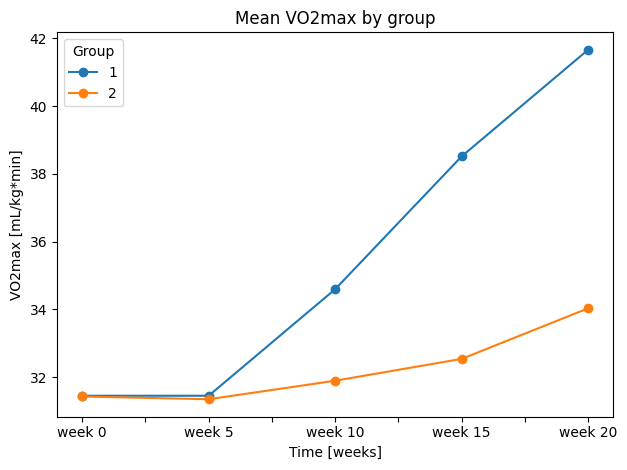

In [3]:
grouped_mean = df.groupby('group', observed=True)[time].mean()
grouped_mean = grouped_mean.T

grouped_mean.plot(kind='line', marker='o')
plt.title('Mean VO2max by group')
plt.xlabel('Time [weeks]')
plt.ylabel('VO2max [mL/kg*min]')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

Iz opisne statistike opazimo, da obstajajo razlike med vrednostmi VO2max med skupinama, prav tako pa obstajajo razlike med vrednostmi VO2max znotraj posamezne skupine. Dokaz, o tem ali je razlika med VO2max znotraj skupine statistično značilna bomo dokazali z ANOVO ponavljajočih meritev. 

**HO:** Med meritvami VO2max v različnih tednih ne obstajajo statistično značilne razlike.

**H1:** Med meritvami V=2max v različnih tednih obstajajo statistično značilne razlike.

#### 2. Statistična analiza

In [5]:
df['subject'] = df.index
df_long = pd.melt(df,
                  id_vars=['subject', 'group'],
                  value_vars=time,
                  var_name='week',
                  value_name='vo2max')

df_long['week'] = df_long['week'].str.extract(r'(\d+)').astype(int)
g_1 = df_long[df_long['group'] == '1'].drop(columns='group')
g_2 = df_long[df_long['group'] == '2'].drop(columns='group')

aov1 = pg.rm_anova(data=g_1, dv='vo2max', within='week', subject='subject', correction=True, detailed=True)
aov2 = pg.rm_anova(data=g_2, dv='vo2max', within='week', subject='subject', correction=True, detailed=True)
anova_rm = pg.rm_anova(data=df_long, dv='vo2max', within='week', subject='subject', correction=True, detailed=True)

display(aov1.style.set_caption('Table 1: Repeated measures ANOVA: group 1').set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('border-bottom', '1px solid black'),
                ('width', '100%')
            ]}]))
display(aov2.style.set_caption('Table 2: Repeated measures ANOVA: group 2').set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('border-bottom', '1px solid black'),
                ('width', '100%')
            ]}]))
display(anova_rm.style.set_caption('Table 3: Repeated measures ANOVA: between groups').set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('border-bottom', '1px solid black'),
                ('width', '100%')
            ]}]))

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,week,1693.065044,4,423.266261,10.955295,0.000000,0.000090,0.205670,0.547904,False,0.079462,0.000001
1,Error,3090.861516,80,38.635769,nan,nan,nan,nan,nan,nan,nan,nan


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,week,209.177775,4,52.294444,4.410350,0.002045,0.006714,0.031102,0.700494,False,0.421798,0.000063
1,Error,1992.011025,168,11.857208,nan,nan,nan,nan,nan,nan,nan,nan


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,week,1235.910500,4,308.977625,13.543153,0.000000,0.000001,0.078624,0.582642,False,0.235260,0.000000
1,Error,5749.204860,252,22.814305,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
posthoc1 = pg.pairwise_tests(data=g_1, dv='vo2max', within='week', subject='subject', parametric=True, padjust='none')
display(posthoc1.style.set_caption('Table 4: Post-hoc for group 1').set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('border-bottom', '1px solid black'),
                ('width', '100%')
            ]}]))

posthoc2 = pg.pairwise_tests(data=g_2, dv='vo2max', within='week', subject='subject', parametric=True, padjust='none')
display(posthoc2.style.set_caption('Table 5: Post-hoc for group 2').set_table_styles([
            {'selector': 'caption', 'props': [
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('border-bottom', '1px solid black'),
                ('width', '100%')
            ]}]))

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,week,0,5,True,True,0.000000,20.000000,two-sided,1.000000,0.228,0.000000
1,week,0,10,True,True,-2.504153,20.000000,two-sided,0.021046,2.73,-0.528872
2,week,0,15,True,True,-3.520126,20.000000,two-sided,0.002152,18.612,-0.918817
3,week,0,20,True,True,-4.250698,20.000000,two-sided,0.000391,82.329,-1.076687
4,week,5,10,True,True,-3.663700,20.000000,two-sided,0.001542,24.827,-0.542719
5,week,5,15,True,True,-3.623760,20.000000,two-sided,0.001692,22.909,-0.932973
6,week,5,20,True,True,-3.858522,20.000000,two-sided,0.000979,36.847,-1.087501
7,week,10,15,True,True,-2.341589,20.000000,two-sided,0.029667,2.067,-0.471744
8,week,10,20,True,True,-3.031089,20.000000,two-sided,0.006597,7.157,-0.707133
9,week,15,20,True,True,-1.418553,20.000000,two-sided,0.171425,0.544,-0.283036


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,week,0,5,True,True,0.122452,42.000000,two-sided,0.903125,0.166,0.014682
1,week,0,10,True,True,-0.816043,42.000000,two-sided,0.419080,0.226,-0.087596
2,week,0,15,True,True,-1.923644,42.000000,two-sided,0.061195,0.884,-0.228372
3,week,0,20,True,True,-3.094762,42.000000,two-sided,0.003499,9.868,-0.466658
4,week,5,10,True,True,-1.030543,42.000000,two-sided,0.308653,0.271,-0.091255
5,week,5,15,True,True,-1.421035,42.000000,two-sided,0.162689,0.419,-0.212941
6,week,5,20,True,True,-2.762709,42.000000,two-sided,0.008470,4.58,-0.430962
7,week,10,15,True,True,-0.850512,42.000000,two-sided,0.399863,0.232,-0.120188
8,week,10,20,True,True,-2.562019,42.000000,two-sided,0.014084,2.967,-0.354975
9,week,15,20,True,True,-2.076509,42.000000,two-sided,0.044003,1.152,-0.265322


#### 3. Metodologija
Primerjali smo vpliv drugačnega treninga na povišanje VO2max pri srednje treniranih moških. Udeležence smo razdelili na eksperimentalno in kontrolno skupino. Vrednosti posamezne skupine za posamezne teden so podane kot povprečje, standardni odklon in variabilnost. Razliko v rezultatih treniranja smo dokazali z ANOVO ponovljivih meritev. Sferičnost smo preverjali z Maulchy-jevim testom. Vrednosti ANOVE smo za tiste pogoje, ki kršijo sferičnost popravili z Greenhous-Geisser popravkom.Meja statistične značilnosti je p<0,05. Statistično analizo smo izvajali v Pythonu z uporabo knjižnic pingouin in statsmodels.

**Intepretacija**: Iz rezultatov v tabelah 1, 2 in 3 lahko vidimo, da je sferičnost v primeru obeh skupin kršena, zato smo popravili p vrednost ANOVE ponovljivih meritev z Greenhouse-Geisser popravkom. Opazimo, da čas treninga statistično značilno vpliva na vrednosti VO2max pri obeh skupinah, kot tudi, da je statistično značilna razlika med vrednostmi VO2max med skupinama. Iz zgornjega grafa lahko razberemo, da je napredek pri skupini 1 večji kot pri skupini 2. Opravimo tudi post-hoc analizo, da ugotovimo v katerem tednu se začne kazati statistično značilna razlika v vrednostih VO2max za prvo skupino in za drugo skupino.

Post-hoc testi pokažejo, da se pri eksperimentalni skupini (1) statistično značilna razlika v meritvah VO2max pojavi že po desetih tednih, medtem ko se pri kontrolni skupini (2), statistučno značilna razlika v meritvah VO2max pokaže šele v 20 tednu. Tudi razlika med začetnim stanjem in končnim je manjša pri kontrolni skupini.

**Zaključek:** Eksperimentalna vadba je bolj primerna za zviševanje VO2max kot kontrolna vadba.